In [284]:
import os
import pandas as pd
from my_funcs.cest_functions import bruker_dataset_creator_csv
from my_funcs.cest_functions import dicom_data_arranger

In [285]:
# Root stats:
general_fn = os.path.abspath(os.curdir)
current_dir = os.getcwd()  # Get the current directory
parent_dir = os.path.dirname(current_dir)  # Navigate up one directory level

# Subject data:
exp_folder_name = '24_08_13_phantoms_BSA_and_EggWhite'
subject_bsa = '20240813_111233_bsa_phantom_BSA10per_pH6p6_6p8_7p0_7p1_7p2__1_1'
subject_eggwhite = '20240813_125235_phantom_eggwhite_pH6p6_6p8_7p0_7p1_7p2_7p3__1_1'

docu_name = 'scan_doc.csv'

In [286]:
subject_bsa_path = os.path.join(parent_dir, 'data', 'scans', exp_folder_name, subject_bsa)
subject_eggwhite_path = os.path.join(parent_dir, 'data', 'scans', exp_folder_name, subject_eggwhite)

current_subject = subject_bsa_path

In [287]:
bruker_dataset_creator_csv

<function my_funcs.cest_functions.bruker_dataset_creator_csv(subject_fn, fp_prtcl_name)>

In [288]:
aacid_fn, _, bruker_dataset_aacid = bruker_dataset_creator_csv(current_subject, 'z_spectrum_1p5')
aacid_data = dicom_data_arranger(bruker_dataset_aacid, aacid_fn)

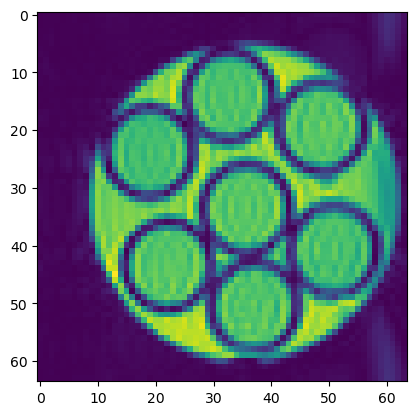

In [289]:
import matplotlib.pyplot as plt
plt.imshow(aacid_data[0,:,:])

In [290]:
import numpy as np
import cv2
from skimage.morphology import binary_erosion, binary_dilation
from skimage.measure import label, regionprops

"""highest contrast image finding:"""
# Compute RMS contrast for each image
count = np.shape(aacid_data)[-1]  # # of images
rms_contrast = np.zeros(count)
for i in range(count):
    rms_contrast[i] = np.std(aacid_data[i, :, :])

# Find index of image with highest contrast
index = np.argmax(rms_contrast)

# Load the image with highest contrast (always 1 out of 2 image options)
contrasted_image = np.transpose(np.uint16(aacid_data[index, :, :]))

"""circle locating:"""
# Binarize the image using thresholding
_, image_binary = cv2.threshold(contrasted_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Perform connected component labeling
label_image = label(~image_binary)

# # Specify the minimum number of pixels for separating regions
# min_pixels = 10
# 
# # Create circular structuring element
# radius = int(min_pixels / 2)
# circular_footprint = np.zeros((min_pixels, min_pixels), dtype=bool)
# y, x = np.ogrid[:min_pixels, :min_pixels]
# mask = (x - radius) ** 2 + (y - radius) ** 2 <= radius ** 2
# circular_footprint[mask] = 1

# # Perform erosion and dilation using circular structuring element
# binary_separated_1 = binary_erosion(label_image != 0, footprint=circular_footprint)
# binary_separated_2 = binary_dilation(binary_separated_1, footprint=circular_footprint)
# 
# d_l_lim = 15
# a_l_lim = 300
# label_image = label(binary_separated_2)
# plt.imshow(binary_separated_1)

# Find the regions that correspond to the circles
circle_regions = []
for region in regionprops(label_image):
    # print(region.equivalent_diameter)
    # print(region.area)
    if 9 < region.equivalent_diameter < 18:
        if 115 < region.area < 150:
            if region.axis_minor_length / region.axis_major_length > 0.5:
                circle_regions.append(region)

# Create a mask for each circle and set the corresponding pixels to one
mask = np.zeros_like(contrasted_image)
for region in circle_regions:
    rr, cc = region.coords[:, 1], region.coords[:, 0]
    mask[rr, cc] = 1

# Set the pixels outside the circles to zero
final_mask = mask

if len(regionprops(label_image)) < 7:
    raise f'Expected 7 circles, but found {len(regionprops(label_image))} circle areas'

"""background locating:"""
# Apply Hough Circle Transform
circles = cv2.HoughCircles(
    np.uint8(image_binary),
    cv2.HOUGH_GRADIENT,
    dp=1,
    minDist=50,
    param1=25,  # Lowering this value allows more circles to be detected
    param2=15,  # Lowering this value allows weaker circles to be detected
    minRadius=20,
    maxRadius=30
)

# Create a mask for a single circle
bg_mask = np.zeros_like(image_binary)
if circles is not None:
    circles = np.uint16(np.around(circles))
    single_circle = circles[0, 0]
    cv2.circle(bg_mask, (single_circle[0], single_circle[1]), single_circle[2], 1, thickness=cv2.FILLED)

bg_mask_logical = bg_mask != 0

kernel_size = 10  # Adjust the kernel size as needed
final_mask_logical = cv2.dilate(final_mask, np.ones((kernel_size, kernel_size), dtype=np.uint8), iterations=1)
final_mask_logical = final_mask_logical != 0

# Create a mask where big circle does not contain the small circle
bg_mask_f = np.logical_and(bg_mask_logical, ~final_mask_logical)
bg_mask_f = bg_mask_f.astype(int)


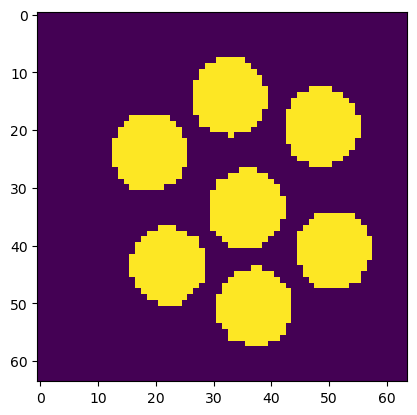

In [291]:
plt.imshow(mask)

In [292]:
circle_regions
# Create a mask for each circle and set the corresponding pixels to one
masks_list = []
for region in circle_regions:
    cur_mask = np.zeros_like(mask)
    rr, cc = region.coords[:, 1], region.coords[:, 0]
    cur_mask[rr, cc] = 1
    masks_list.append(cur_mask)

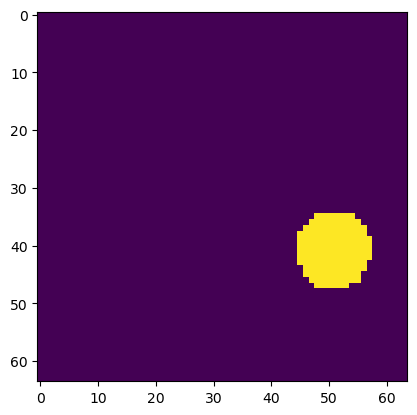

In [293]:
plt.imshow(masks_list[6])
# ph_list = [7.42, 6.75, 7.29, 6.55, 7.04, 7.21, 7.09]
ew_ph_list = [6.8, 6.99, 7.53, 6.58, 7.11, 7.3, 7.21]

In [294]:
from my_funcs.cest_functions import z_spec_rearranger, offset_rearranger, wassr_b0_mapping, b0_correction

# z-spec for roi
def correct_b0(glu_mouse_fn, mask):
    # given:
    gyro_ratio_hz = 42.5764  # for H [Hz/uT]
    b0 = 7
    
    b1_names = ['1p5uT']
    
    # WASSR image
    wassr_dicom_fn, wassr_mrf_files_fn, wassr_bruker_dataset = bruker_dataset_creator_csv(glu_mouse_fn, 'wasser')
    wassr_data = dicom_data_arranger(wassr_bruker_dataset, wassr_dicom_fn)
    M0_wassr, arr_wassr_spec = z_spec_rearranger(wassr_data)  # (21, 64, 64)
    
    wassr_norm = np.divide(arr_wassr_spec, np.where(M0_wassr == 0, 1e-8, M0_wassr))  # (22, 64, 64) full_mask
    offset_hz = offset_rearranger(wassr_bruker_dataset['SatFreqList'].value)
    offset_ppm = offset_hz / (gyro_ratio_hz * b0)
    b0_map = wassr_b0_mapping(wassr_norm, mask, w_x=offset_ppm, MainFieldMHz=gyro_ratio_hz * b0)
    
    z_dict = {}
    for b1_i, b1_name in enumerate(b1_names):  # 0.7, 1.5, 2, 4, 6
        b1_dict = {}
        # z-spec
        glu_phantom_dicom_fn, glu_phantom_mrf_files_fn, bruker_dataset = bruker_dataset_creator_csv(glu_mouse_fn, 'z_spectrum_1p5')  # (72/58/52, 64, 64) [M0,7,-7,6.75,-6.75,...,0.25,-0.25,0]
        cest_data = dicom_data_arranger(bruker_dataset, glu_phantom_dicom_fn)
        M0_cest, arr_z_spec = z_spec_rearranger(cest_data)
        z_spec_norm = np.divide(arr_z_spec, np.where(M0_cest == 0, 1e-8, M0_cest))  # (51/57, 64, 64) full_mask
    
        # offset vector
        offset_hz = offset_rearranger(bruker_dataset['SatFreqList'].value)
        offset_ppm = offset_hz / (gyro_ratio_hz * b0)
    
        b0_cor_zspec = b0_correction(b0_map, z_spec_norm, offset_hz)  # have not checked!
        
        fr_s = int(bruker_dataset['SatFreqStart'].value)
        fr_e = int(bruker_dataset['SatFreqEnd'].value)
        fr_i = round(bruker_dataset['SatFreqInc'].value, 2)
    
        ppm = np.arange(fr_s, fr_e-fr_i, -fr_i)
    
        b1_dict['ppm'] = ppm
        b1_dict['M0'] = M0_cest
        b1_dict[f'z_b1cor'] = b0_cor_zspec
        b1_dict[f'z_nob1cor'] = z_spec_norm
        z_dict[f'{b1_name}'] = b1_dict
        
    return z_dict

In [295]:
# from scipy.interpolate import splev, splrep
# 
# def aacid_roi(subject_dict, z_dict, roi_mask):
#     # Iterate over each channel
#     for b1_i, b1_name in enumerate(subject_dict['z_b1s_names']):
#         # Iterate over each image
#         ppm = z_dict[b1_name]['ppm']
#         M0 = z_dict[b1_name]['M0']
#         z_b1cor = z_dict[b1_name]['z_b1cor']
#         z_nob1cor = z_dict[b1_name]['z_nob1cor']
#     
#         cha_n, r_n, c_n = z_b1cor.shape
#     
#         if b1_name == '1p5uT':
#             MainFieldMHz = 298
#             B1_uT = 1.5
#             gyro_ratio_hz = 42.5764
#             w1_Hz = round(B1_uT*gyro_ratio_hz)  # satpwr for scan (Hz)
#             w_Hz = ppm * MainFieldMHz  # Scanned frequency offsets (ppm * MHz = Hz)
#     
#             # Calculate mean value for each channel in the masked regions (excluding zeros)
#             roi_mask = roi_mask.astype(bool)
#             expanded_roi_mask = np.repeat(roi_mask[np.newaxis, :, :], z_b1cor.shape[0], axis=0)
# 
#             masked_z_b1cor = np.ma.masked_where(expanded_roi_mask == 0, z_b1cor)
#             roi_mean_z = np.mean(masked_z_b1cor, axis=(1,2))
#             Interp_w_Hz = np.arange(min(w_Hz), max(w_Hz)+1, 1)  # Spline interpolation of scanned offsets every 1 Hz
#             tck = splrep(w_Hz[::-1], roi_mean_z[::-1], s=0)  # Spline representation of the data (I needed to reverse)
#             M_2p75 = splev(2.75*MainFieldMHz, tck)
#             M_3p5 = splev(3.5*MainFieldMHz, tck)
#     
#             M_6 = roi_mean_z[np.argmin(abs(ppm-6))]
#             aacid_roi = (M_3p5 * (M_6 - M_2p75)) / (M_2p75 * (M_6 - M_3p5))
#     
#             ph_roi = (-4*aacid_roi + 12.8)  # in-vivo calibration
#             # ph_roi = (aacid_roi - 6.5) / (-0.64)  # in-vitro calibration
#             # ph_roi = (aacid_roi - 1.79) / (-0.236)  # in-vitro egg calibration physiological (not accurate!!!)
#             # ph_roi = (aacid_roi - 1.95) / (-0.176)  # in-vitro egg calibration all (not accurate!!!)
#             
#     return aacid_roi, ph_roi, roi_mean_z

In [296]:
from scipy.interpolate import splev, splrep

z_dict = correct_b0(current_subject, mask)
for b1_i, b1_name in enumerate(['1p5uT']):
    # Iterate over each image
    ppm = z_dict[b1_name]['ppm']
    z_b1cor = z_dict[b1_name]['z_b1cor']
    z_nob1cor = z_dict[b1_name]['z_nob1cor']

    cha_n, r_n, c_n = z_b1cor.shape

    aacid_map = np.zeros([r_n, c_n])
    if b1_name == '1p5uT':
        MainFieldMHz = 298
        B1_uT = 1.5
        gyro_ratio_hz = 42.5764
        w1_Hz = round(B1_uT*gyro_ratio_hz)  # satpwr for scan (Hz)

        w_Hz = ppm * MainFieldMHz  # Scanned frequency offsets (ppm * MHz = Hz)

        Interp_w_Hz = np.arange(min(w_Hz), max(w_Hz)+1, 1)  # Spline interpolation of scanned offsets every 1 Hz
        for r_i in range(r_n):
            for c_i in range(c_n):
                if mask[r_i, c_i] != 0:
                    cur_z = z_b1cor[:, r_i, c_i]
                    tck = splrep(w_Hz[::-1], z_b1cor[::-1, r_i, c_i], s=0)  # Spline representation of the data (I needed to reverse)
                    M_2p75 = splev(2.75*MainFieldMHz, tck)
                    M_3p5 = splev(3.5*MainFieldMHz, tck)
                    # M_2 = z_b1cor[np.argmin(abs(ppm-2)), r_i, c_i]
                    M_6 = z_b1cor[np.argmin(abs(ppm-6)), r_i, c_i]
                    
                    aacid_map[r_i, c_i] = (M_3p5 * (M_6 - M_2p75)) / (M_2p75 * (M_6 - M_3p5))
                    # aacid_map[r_i, c_i] = (M_3p5 * (M_6 - M_2)) / (M_2 * (M_6 - M_3p5))
                    
                    # ph = (AACID - 6.5) / (-0.64)
                    
                    # # Add scatter plot z-spectrum element
                    # z_fig.add_trace(go.Scatter(
                    #     x=ppm,
                    #     y=cur_z,
                    #     mode='lines',
                    #     line=dict(color='blue', width=2),
                    #     opacity=0.5
                    # ), row=row_i, col=1)


WASSR B0 mapping took 3.513 seconds


In [297]:
mean_list = []
std_list = []
txt_list = []
for vial_i in range(7):
    vial_masked_aacid = np.ma.masked_where(masks_list[vial_i] == 0, aacid_map)
    vial_roi_mean_pixels_aacid = f'{np.mean(vial_masked_aacid):.2f} ± {np.std(vial_masked_aacid):.2f}'
    txt_list.append(vial_roi_mean_pixels_aacid)
    mean_list.append(np.mean(vial_masked_aacid))
    std_list.append(np.std(vial_masked_aacid))

In [298]:
import plotly.graph_objects as go

bsa_ph_list = [7.42, 6.75, 7.29, 6.55, 7.04, 7.21, 7.09]

# Calculate the linear fit
coefficients = np.polyfit(bsa_ph_list, mean_list, 1)
line_fit = np.polyval(coefficients, bsa_ph_list)

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=bsa_ph_list, y=mean_list, mode='markers', name='Data Points',
        error_y=dict(
        type='data',  # Use the given data
        array=std_list,  # Standard deviations
        visible=True  # Show error bars
    )))
# Add linear fit line
fig.add_trace(go.Scatter(x=bsa_ph_list, y=line_fit, mode='lines', name='Linear Fit'))

# Add title and labels
fig.update_layout(
    title='BSA AACID',
    xaxis_title='pH',
    yaxis_title='mean AACID',
    template='plotly_white',  # Light mode with dark text
    width=550,  # Adjust the width to make the plot narrower
    height=400  # Optionally, adjust the height as well
)

# Show the plot
fig.show()

In [299]:
ew_ph_list = [6.8, 6.99, 7.53, 6.58, 7.11, 7.3, 7.21]

# Calculate the linear fit
coefficients = np.polyfit(ew_ph_list, mean_list, 1)
line_fit = np.polyval(coefficients, ew_ph_list)

# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=ew_ph_list, y=mean_list, mode='markers', name='Data Points',
        error_y=dict(
        type='data',  # Use the given data
        array=std_list,  # Standard deviations
        visible=True  # Show error bars
    )))
# Add linear fit line
fig.add_trace(go.Scatter(x=ew_ph_list, y=line_fit, mode='lines', name='Linear Fit'))

# Add title and labels
fig.update_layout(
    title='Egg White AACID',
    xaxis_title='pH',
    yaxis_title='mean AACID',
    template='plotly_white',  # Light mode with dark text
    width=550,  # Adjust the width to make the plot narrower
    height=400  # Optionally, adjust the height as well
)

# Show the plot
fig.show()

In [300]:
# # ph_map = (aacid_map - 6.1357681)/-0.6265661  # my bsa calibration
# # ph_map = (aacid_map - 6.5) / (-0.64)  # their bsa calibration
# # Compute the transformation in slope and intercept
# delta_m = -0.64 - (-0.6265661)
# delta_c = 6.5 - 6.1357681
# 
# # Apply the transformation to Line 3
# m3_transformed = -0.25 + delta_m
# c3_transformed = 3.2 + delta_c
# y3_transformed = np.polyval([m3_transformed, c3_transformed], x)

In [301]:
# AACID_bsa    = -0.64      * ph + 6.5        # their bsa calibration
# AACID_bsa_my = -0.6265661 * ph + 6.1357681  # my bsa calibration

# AACID = -0.25 * ph + 3.2  
# AACID_proj = -0.2365661 * ph + 2.8357681
# ph = (aacid - 2.8357681) / -0.2365661
m1, c1 = -0.64, 6.5
m2, c2 = -0.6265661, 6.1357681
m3, c3 = -0.25, 3.2
# Calculate the transformation (delta)
delta_m = m2 - m1
delta_c = c2 - c1

# Apply the transformation to Line 3 to get Line 4
m4 = m3 + delta_m
c4 = c3 + delta_c



In [302]:
import plotly.express as px

fig = px.imshow(aacid_map, zmin=2, zmax=3)
# fig = px.imshow(aacid_map, zmin=1.2, zmax=2.5)
fig.show()
